In [1]:
import iminuit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import obspy.signal.filter

import obspy

import CohesiveCrack
import DataProcessor
import PlotFunctions

In [2]:
Gamma = 0.21  # Fracture energy (J/m^2)
E = 51e9      # Young's modulus (Pa)
nu = 0.25     # Poisson's ratio
C_f = 2404    # Rupture speed (m/s)
C_s = 2760    # Shear wave speed (m/s)
C_d = 4790    # Longitudinal wave speed (m/s)

In [3]:
experiment_SN = 'p5993'
normal_stress = 20 * 10**6 # Pa

In [4]:
filename = f'../Data/{experiment_SN}e.npz'

In [5]:
run_number = 2
event_number = 8

In [6]:
PROMINENCES = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
DISTANCES = [30, 30, 30, 30, 30, 30, 30, 30, 30]

X_C_INITIALS = [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]
GAMMA_INITIALS = [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]
PEAK_INDEXS = [0, 0, 0, 0, 0, 0, 0, 0, 0]
PEAK_FIND_SPAN = [120, 120, 120, 220, 120, 120, 120, 120, 120]

MAX_INDEXS = [np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]

# to be refine: 
#   1) event_number:

In [7]:
data = np.load(filename, allow_pickle = True)
data = data["experiment"][()]
event = data['runs'][1]['events'][event_number]
exy6 = event['strain']['original']['raw'][6]


TIME_S = event['strain']['original']['time']
C_f = np.abs(event['rupture_speed'])
print(f'Cf: {C_f:.1f}m/s')

fs = len(TIME_S) / (np.max(TIME_S) - np.min(TIME_S))
print(f'Sampling rate: {fs:.1f}Hz')

DISTANCE = TIME_S * C_f * 1000 # mm


STRAIN = DataProcessor.voltage_to_strain(exy6)
STRESS = DataProcessor.shear_strain_to_stress(E, nu, STRAIN)
STRESS = STRESS - STRESS[0]
STRESS_MPA = STRESS / 10**6
STRESS_MPA *= -1

Cf: 1680.0m/s
Sampling rate: 100000.2Hz


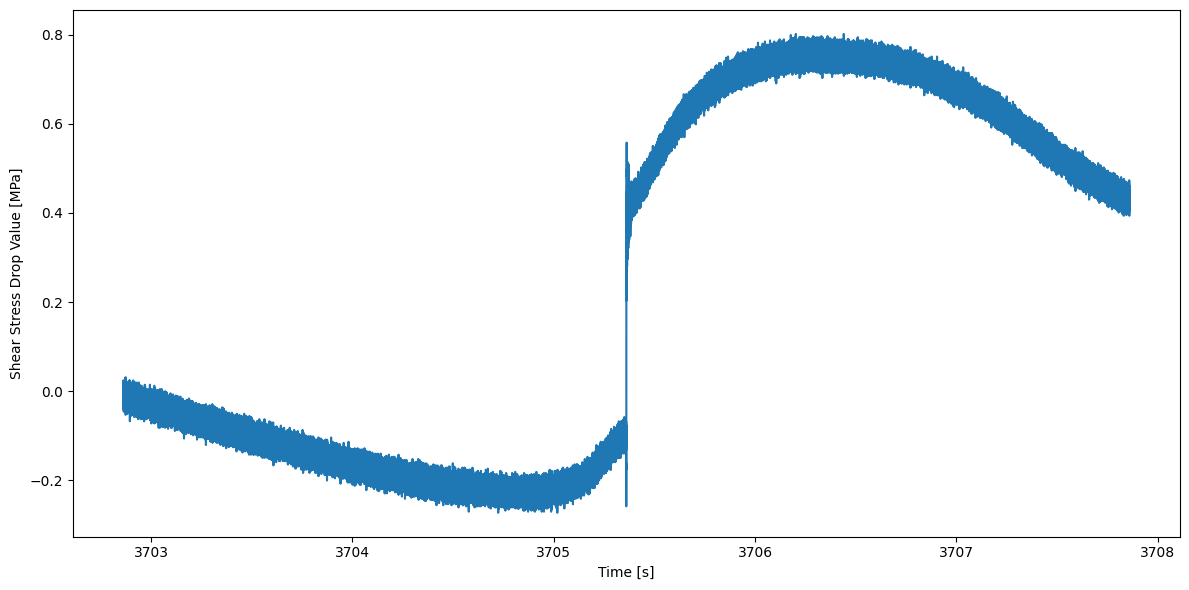

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(TIME_S, STRESS_MPA, label=r'$\epsilon_{xy}$')
plt.xlabel('Time [s]')
plt.ylabel('Shear Stress Drop Value [MPa]')
plt.tight_layout()
# plt.savefig(f'../Plot/{experiment_SN}-DECONV1.pdf', dpi = 300)
plt.show()
plt.close()

In [9]:
STRAINS = list(event['strain']['original']['raw'][0:13])
STRAINS_CUT = []

cutoff = 100
cutoff = 200

cutoff_list = [100, 200, 300, 400, 500, 600]

for ii in range(len(STRAINS)):
    
    temp = STRAINS[ii][249500:250500]
    temp = temp - np.average(temp)
    temp = DataProcessor.highpass_filter(temp, cutoff, fs)
    temp = temp - np.average(temp)
    temp = DataProcessor.apply_taper(temp)
    
    temp = DataProcessor.shear_strain_to_stress(E, nu, temp)
    temp = temp - temp[0]
    temp = temp / 10**6
    
    STRAINS_CUT.append(temp)
# loc = PlotFunctions.do_waveform_plot(STRAINS_CUT, fs)

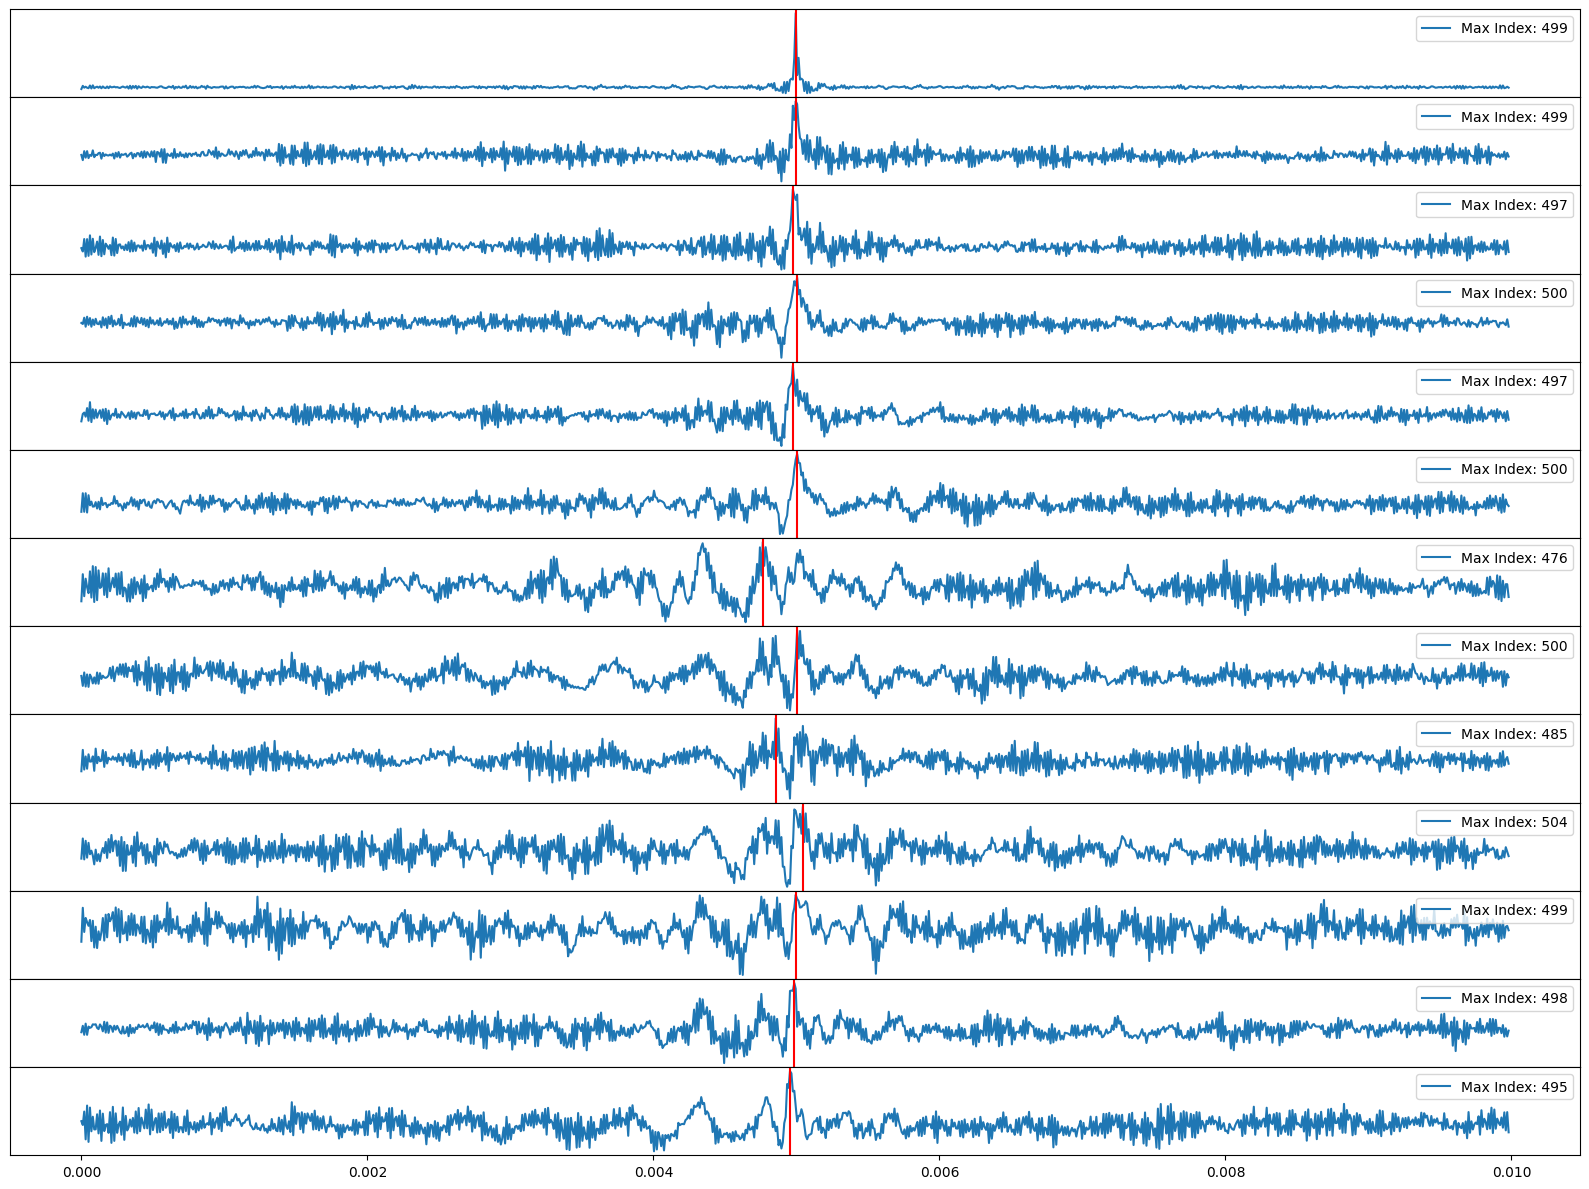

In [10]:
STRAINS_CUT_DECONV = []

for jj in range(len(STRAINS_CUT)):
    STRAINS_CUT_DECONV.append(DataProcessor.do_deconvolution(STRAINS_CUT[0], STRAINS_CUT[jj]))
    
loc = PlotFunctions.do_waveform_plot(STRAINS_CUT_DECONV, fs)

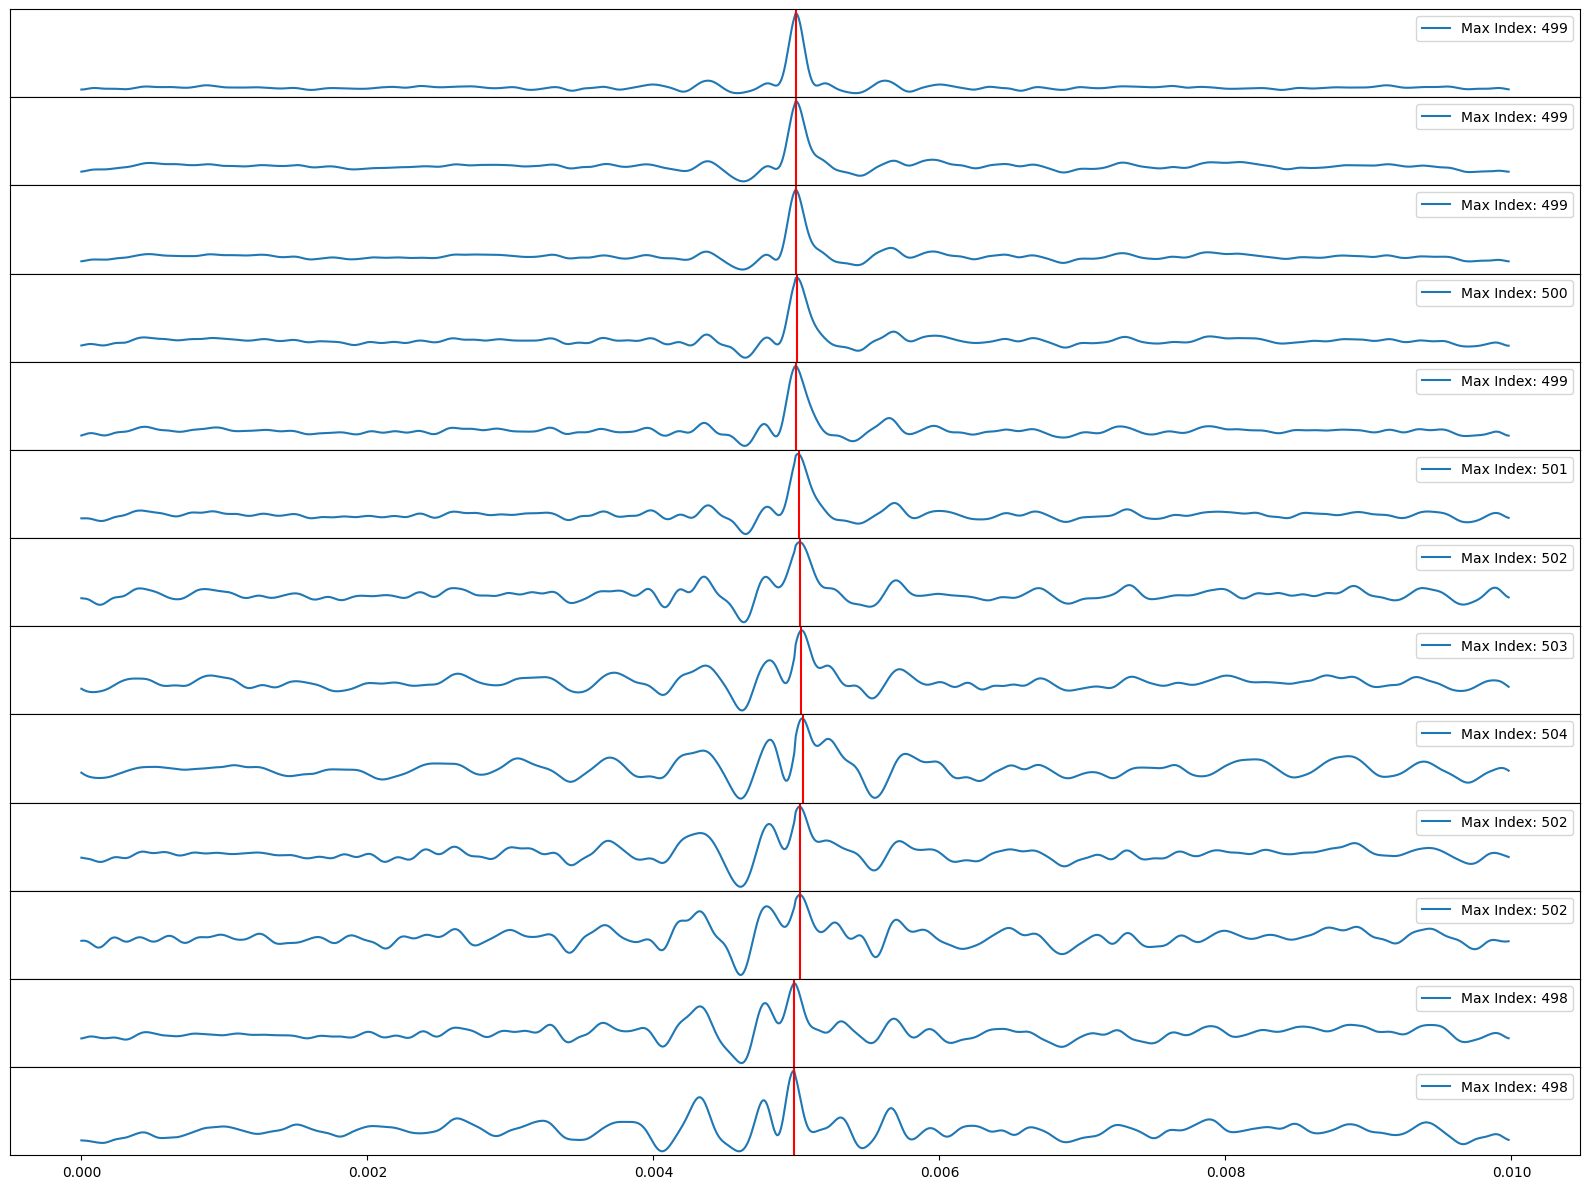

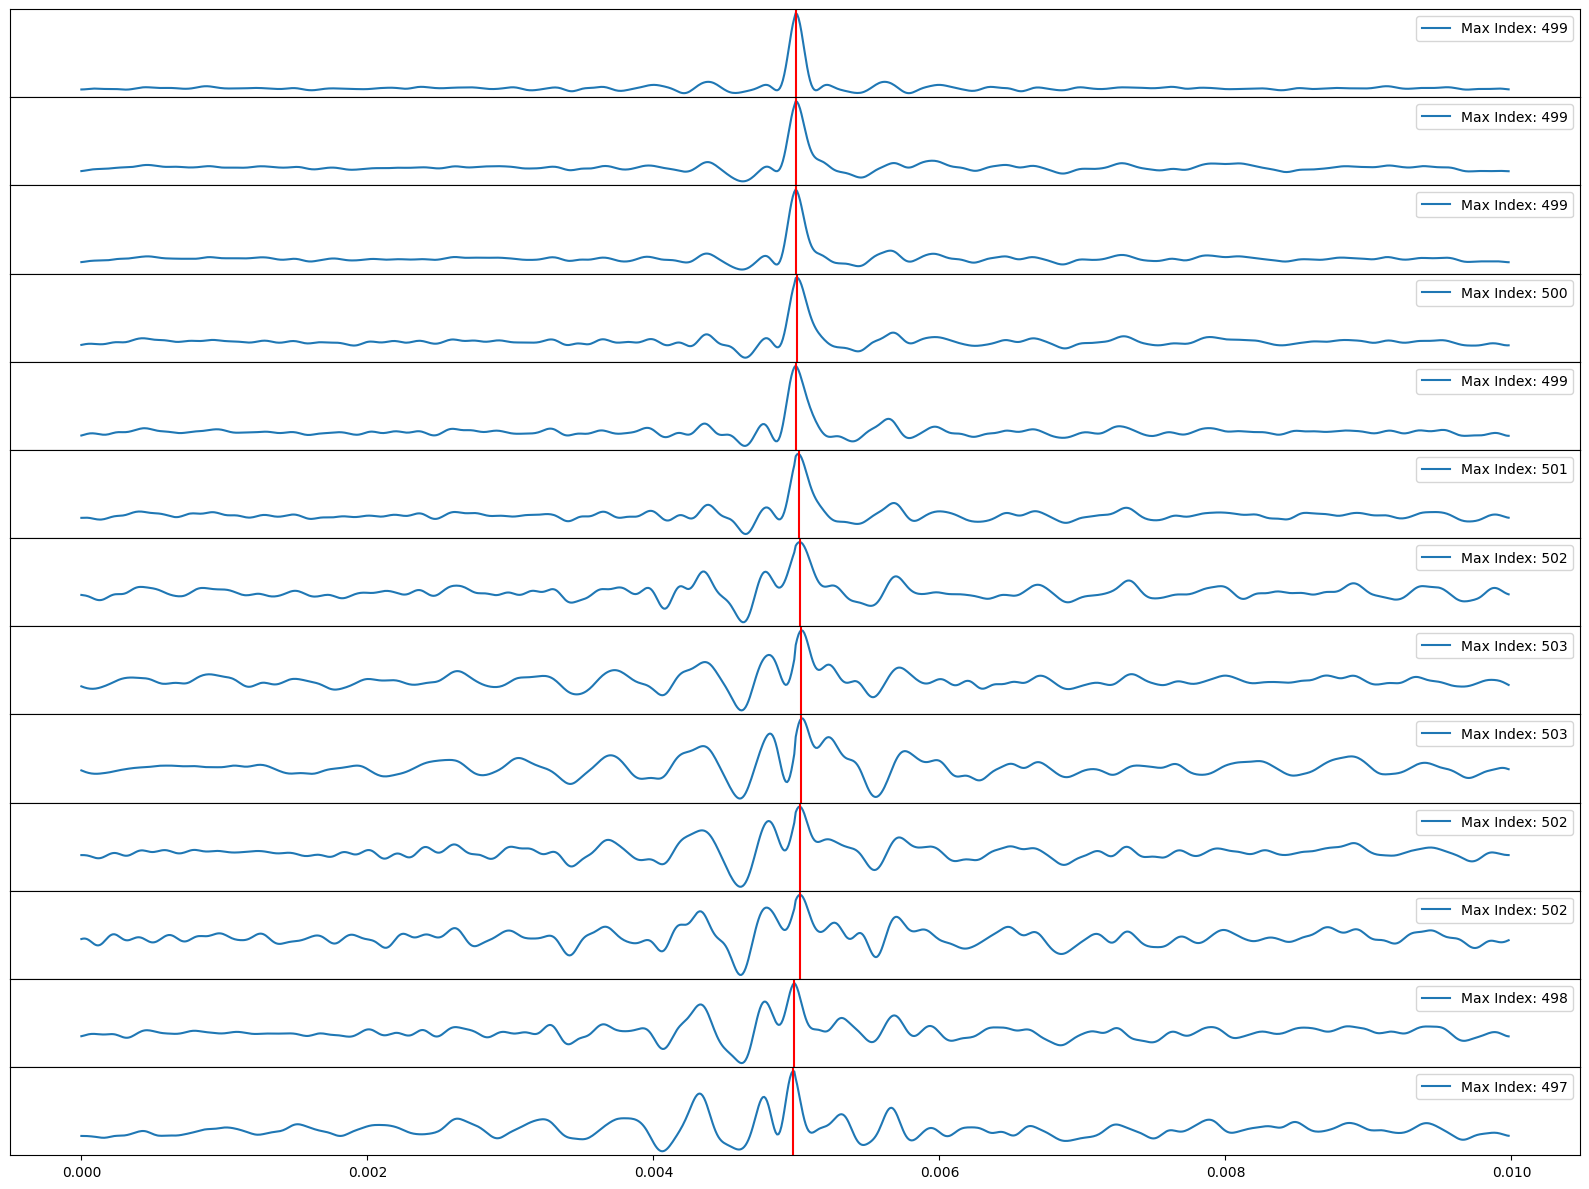

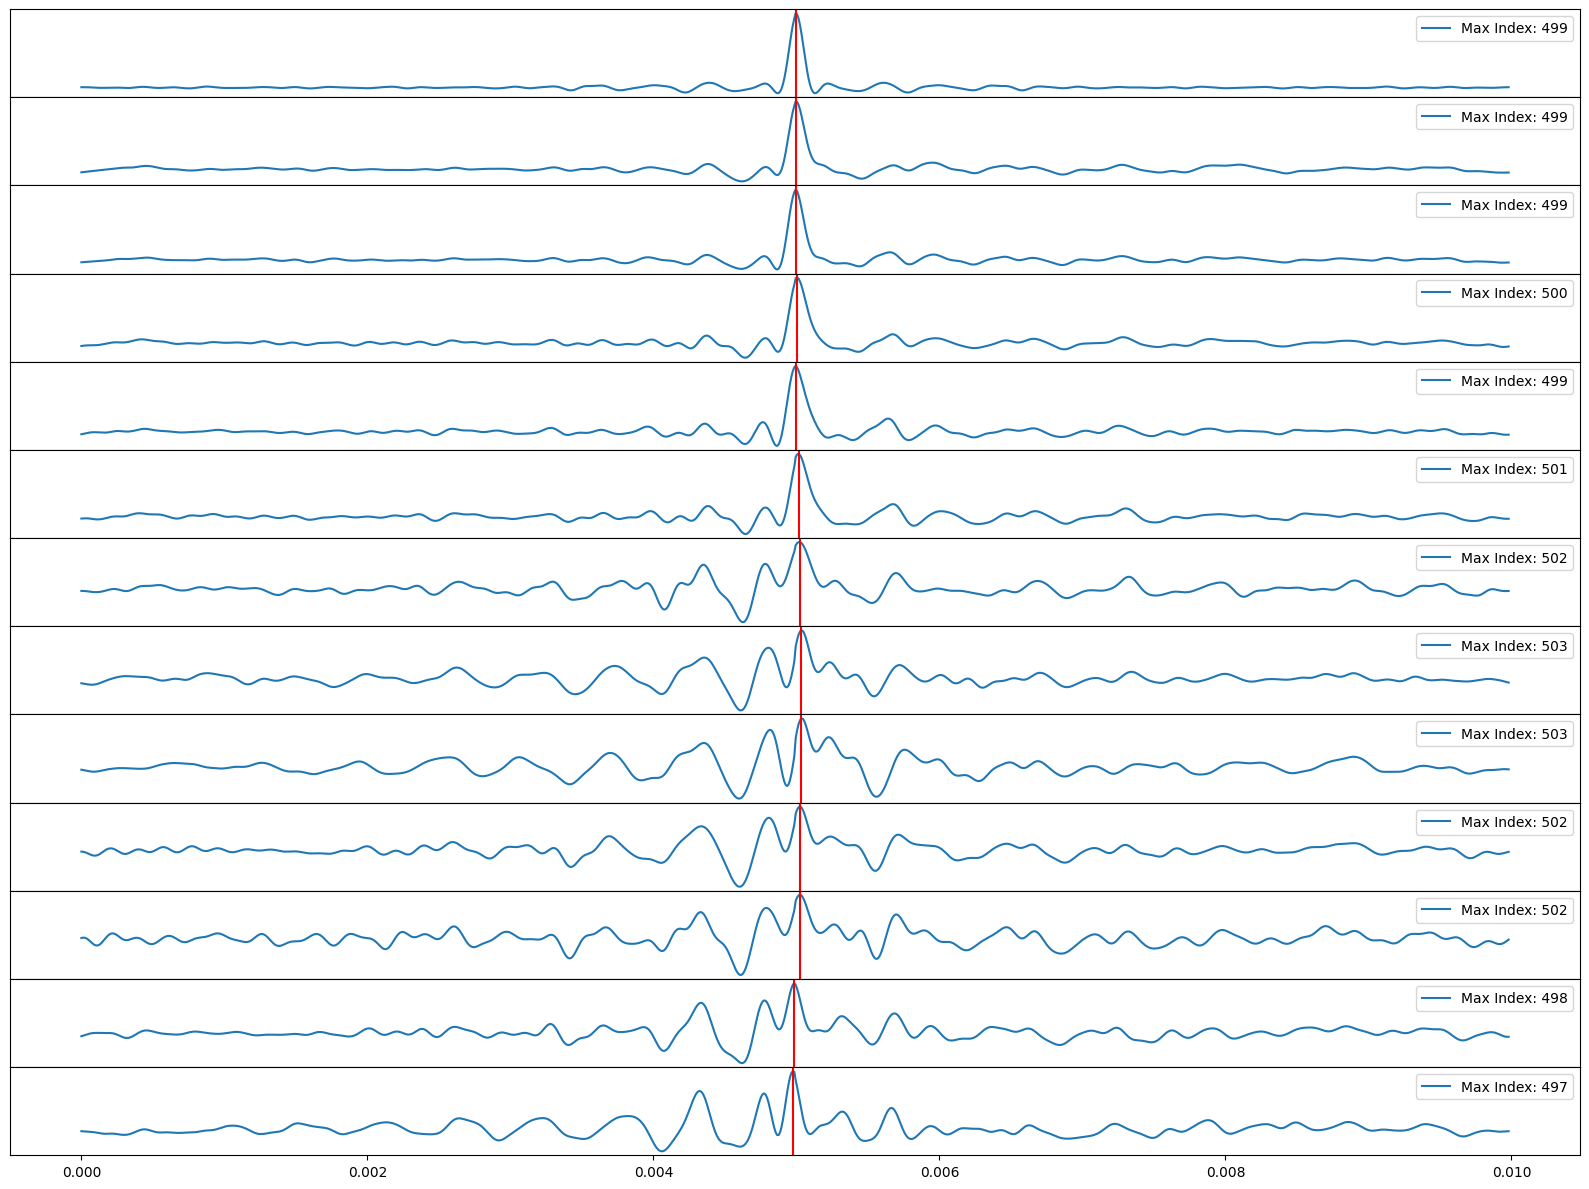

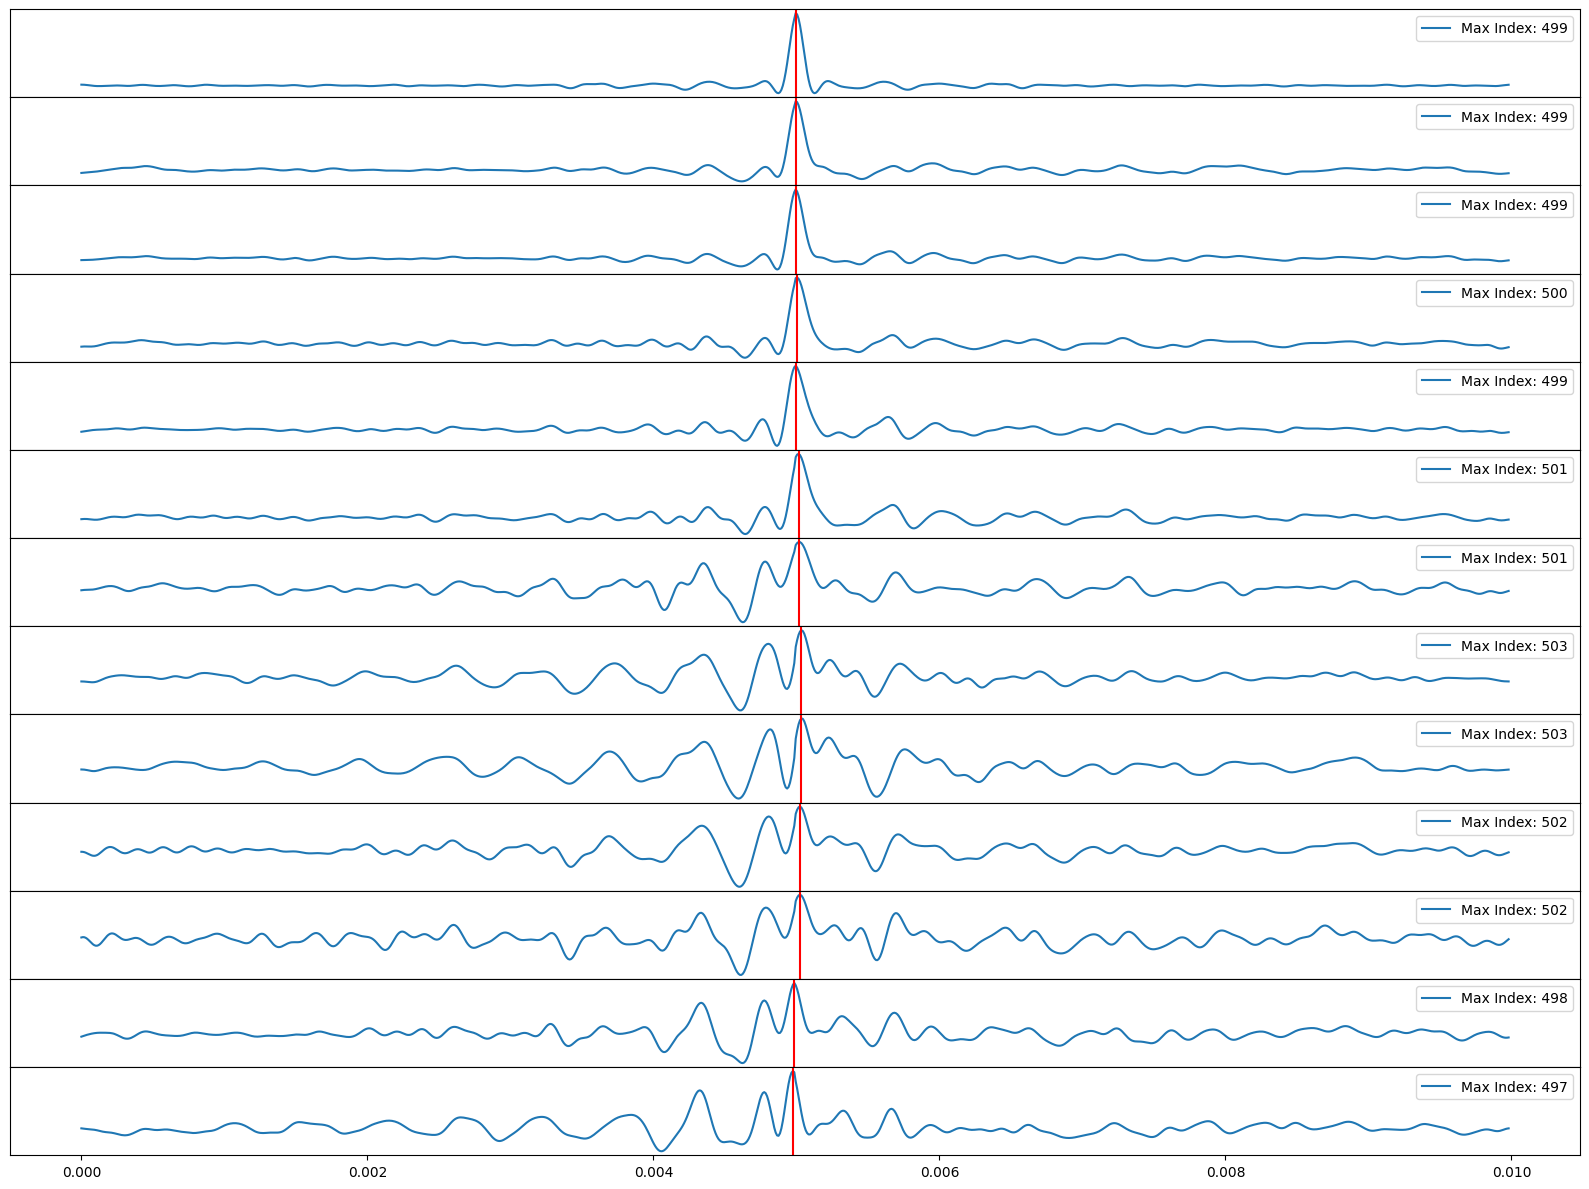

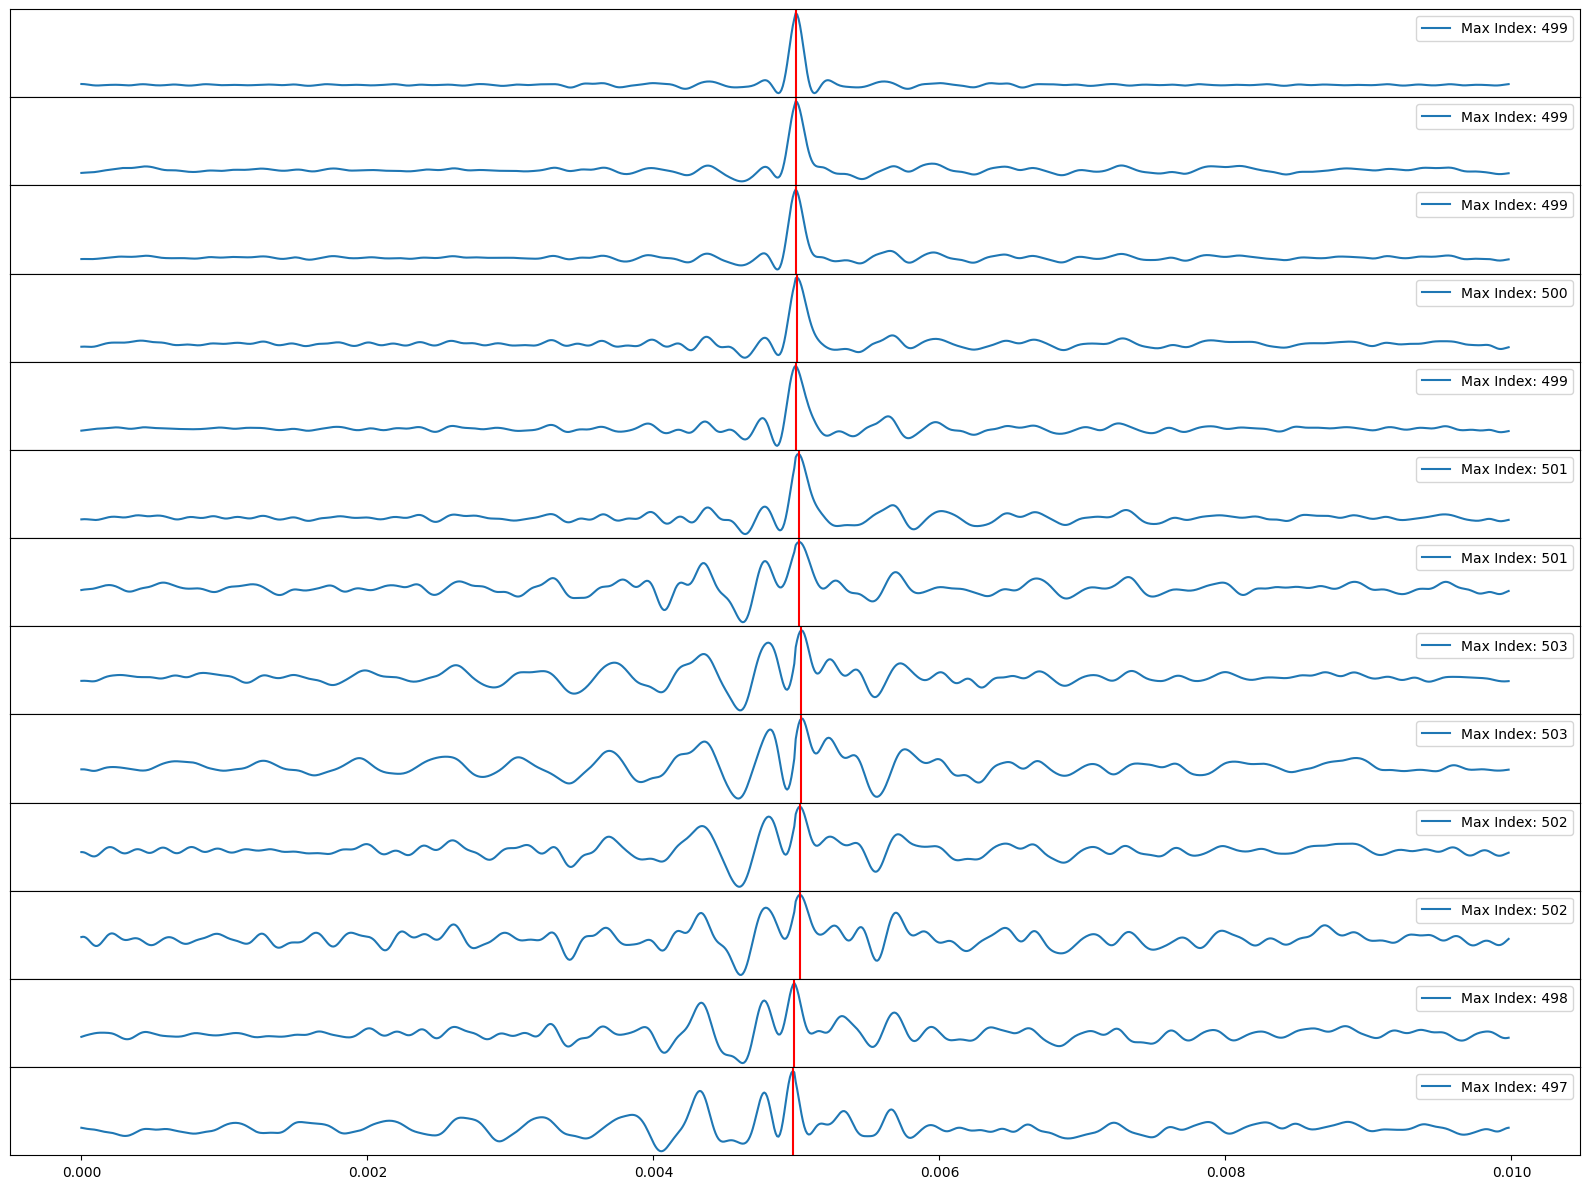

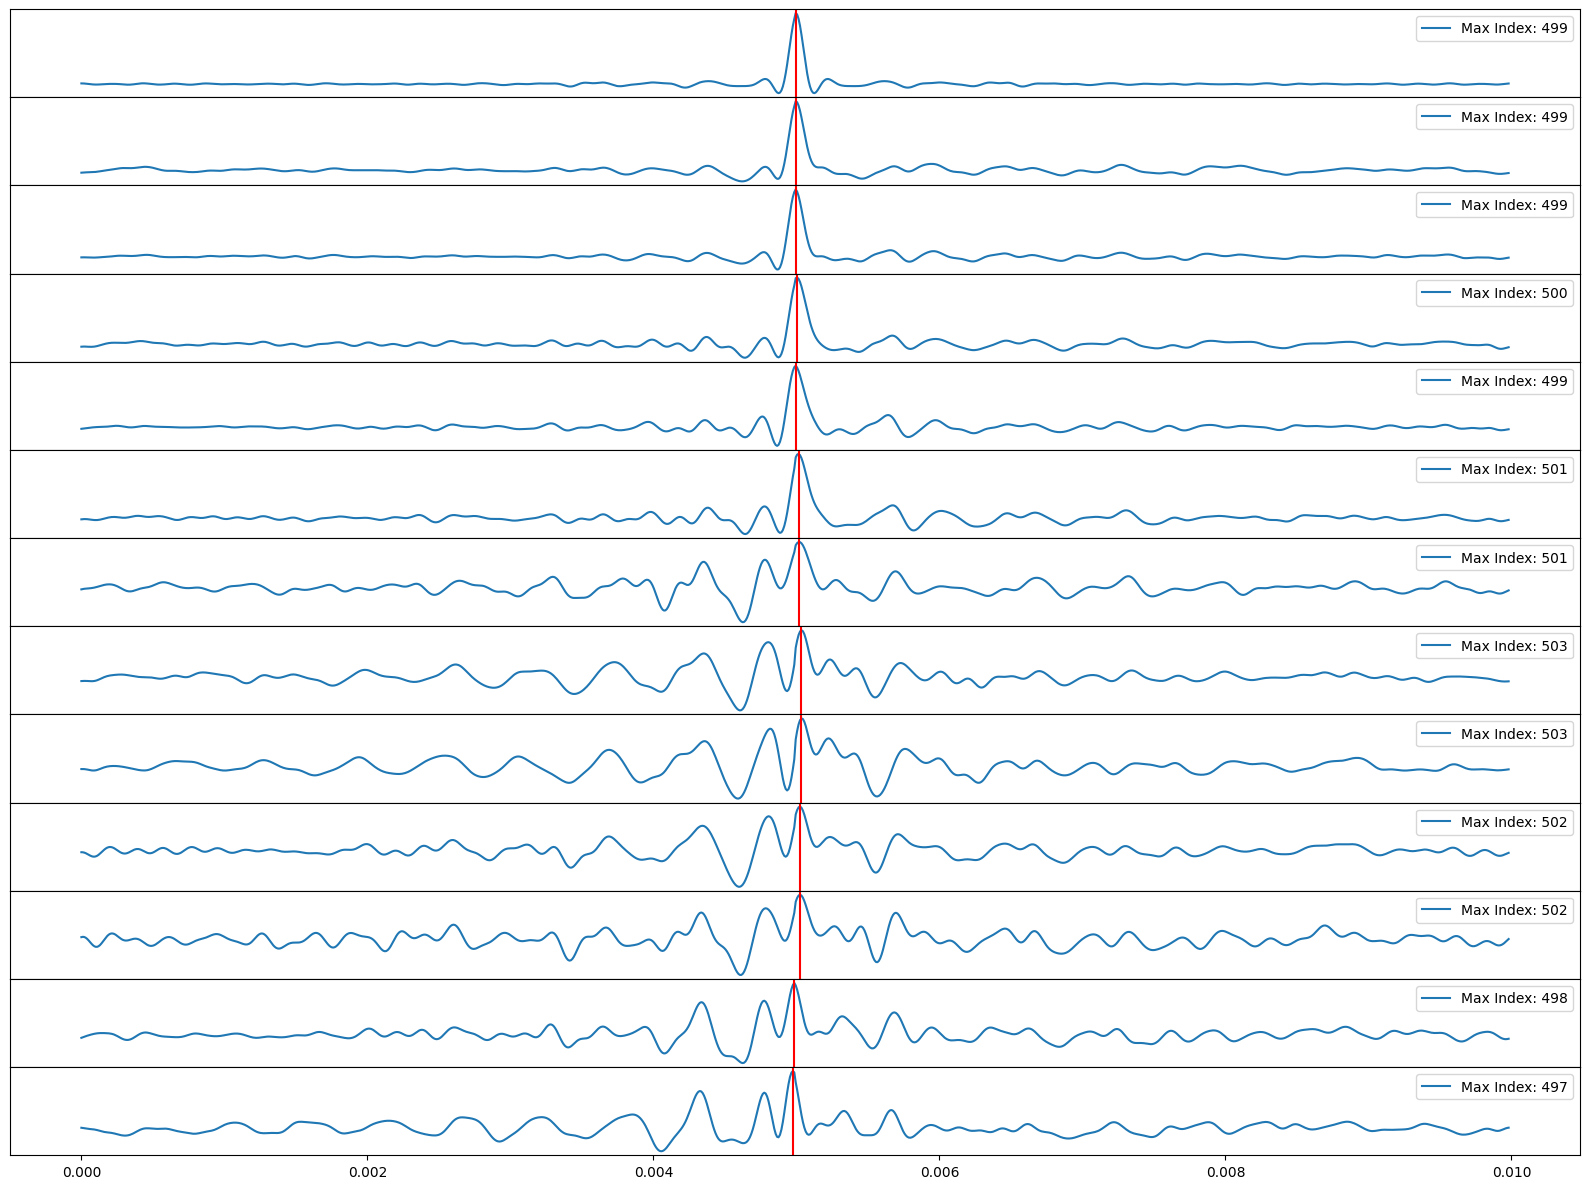

In [11]:
for cutoff in cutoff_list:
    STRAINS_CUT = []

    for ii in range(len(STRAINS)):
        
        temp = STRAINS[ii][249500:250500]
        temp = temp - np.average(temp)
        temp = obspy.signal.filter.bandpass(temp, cutoff / 10, 6000, fs, 4, True)
        temp = temp - np.average(temp)
        temp = DataProcessor.apply_taper(temp)
        
        temp = DataProcessor.shear_strain_to_stress(E, nu, temp)
        temp = temp - temp[0]
        temp = temp / 10**6
        
        STRAINS_CUT.append(temp)
        
    STRAINS_CUT_DECONV = []

    for jj in range(len(STRAINS_CUT)):
        STRAINS_CUT_DECONV.append(DataProcessor.do_deconvolution(STRAINS_CUT[0], STRAINS_CUT[jj]))
        
    loc = PlotFunctions.do_waveform_plot(STRAINS_CUT_DECONV, fs)